Script volcanic ash detection by using RGB Composite Technique along with Treshold Method.

Cretaed by Ulil Hidayat (ulil.hidayat@bmkg.go.id)
Reference:
- https://ulil-hidayat.github.io/2024/01/18/volcanic-ash.html
- https://issuu.com/antasena/docs/vol.4_no.1_januari-juni2019_opt/s/10202752



In [1]:
# import module 
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib.image as im
from PIL import Image
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import ListedColormap


In [2]:
#RGB SPecial for VA but we use for smoke detection
def rgb1(data1, data2, data3, PATH, title, circles=[]):
    ds1 = Dataset(data1,'r')
    ds2 = Dataset(data2,'r')
    ds3 = Dataset(data3,'r')

    b11 = ds1.variables['tbb'][:]
    b13 = ds2.variables['tbb'][:]
    b15 = ds3.variables['tbb'][:]
    lons = ds1.variables['longitude'][:]
    lats = ds1.variables['latitude'][:]

    #RGB Composition
    red = b15-b13
    green = b13-b11
    blue = b13

    def norm(band):
        band_min, band_max = np.nanpercentile(band,2), np.nanpercentile(band,98)
        return ((band-band_min)/(band_max-band_min))

    r = norm(red.astype(float))
    g = norm(green.astype(float))
    b = norm(blue.astype(float))

    rgb = np.dstack((r,g,b))
    extent = [90, 150, -20, 20]

    below,above,left,right = -3, 7, 108, 128 #AOI 
    m = Basemap(projection='cyl',resolution='h',llcrnrlat=below,llcrnrlon=left,urcrnrlat=above,urcrnrlon=right)
    m.drawcoastlines(color='white')
    #m.drawparallels(np.arange(-90,90,3),labels=[1,0,0,1],dashes = [5,5], fontsize=8)
    #m.drawmeridians(np.arange(-180,180,3),labels=[1,0,0,1],dashes = [5,5],fontsize=8)

    # Plot red circles
    for circle in circles:
        lon, lat, radius = circle
        x, y = m(lon, lat)
        m.scatter(x, y, marker='o', edgecolors='red', linewidths=1, facecolors='none', s=1000, label='Red Circle')


    title_cleaned = ''.join(c for c in title if c.isalnum() or c in [' ', '_', '-'])


    plt.imshow(rgb, extent=extent)
    plt.title(title)
    plt.savefig(f"{title_cleaned}.png")  # Save each plot as a PNG file
    plt.show()

In [3]:
#RGB SPecial for VA mask
def rgb2(data1, data2, data3, PATH, title, circles=[]):
    ds1 = Dataset(data1,'r')
    ds2 = Dataset(data2,'r')
    ds3 = Dataset(data3,'r')

    b11 = ds1.variables['tbb'][:]
    b13 = ds2.variables['tbb'][:]
    b15 = ds3.variables['tbb'][:]
    lons = ds1.variables['longitude'][:]
    lats = ds1.variables['latitude'][:]

    #RGB Composition
    red = b15-b13
    green = b13-b11
    blue = b13

    def norm(band):
        band_min, band_max = np.nanpercentile(band,2), np.nanpercentile(band,98)
        return ((band-band_min)/(band_max-band_min))

    r = norm(red.astype(float))
    g = norm(green.astype(float))
    b = norm(blue.astype(float))

    rgb = np.dstack((r,g,b))
    #extent = [90, 150, -20, 20]


    # Thresholding to create binary mask
    #threshold = 0.5  # Adjust this threshold as needed
    #binary_mask = (g > threshold).astype(int)  # Ash pixels will be 1, non-ash pixels will be 0

    # Define color thresholds1 
    #------------------#
    red_tres = 0
    green_tres = 0.9
    #green_tres_2 = 0.915
    blue_tres = 0

    red_mask = r > red_tres
    #green_mask = np.logical_and(g > green_tres, g < green_tres_2)
    green_mask = g > green_tres
    blue_mask = b > blue_tres 

    ash_mask = np.logical_and(red_mask, green_mask, blue_mask).astype(int)
    #----------------#

    # Define color threshold2
    #--------------#
    red_tres2 = 0.95
    green_tres2 = 0.6
    #green_tres_2 = 0.915
    blue_tres2 = 0

     # Create binary mask based on color thresholds
    red_mask2 = r > red_tres2
    #green_mask = np.logical_and(g > green_tres, g < green_tres_2)
    green_mask2 = g > green_tres2
    blue_mask2 = b > blue_tres2 

    # Combine masks using logical OR operation
    ash_mask2 = np.logical_and(red_mask2, green_mask2, blue_mask2).astype(int)
    #------------------#

    # Define color threshold3
    #--------------#
    #red_tres3 = 1
    #green_tres3 = 0
    #blue_tres3 = 1

    # Create binary mask based on color thresholds
    #red_mask3 = r > red_tres3
    #green_mask = np.logical_and(g > green_tres, g < green_tres_2)
    #green_mask3 = g > green_tres3
    #blue_mask3 = b > blue_tres3

    # Combine masks using logical OR operation
    #ash_mask3 = np.logical_and(red_mask3, green_mask3, blue_mask3).astype(int)
    #------------------#

    # Combine ash_mask and ash_mask2 using logical OR operation
    combined_ash_mask = np.logical_or(ash_mask, ash_mask2).astype(int)

    # Define custom colors for the binary colormap
    colors = ['gray', '#964B00']  # Define blue and green colors
    alpha = [1, 0]  # Define alpha values corresponding to the colors

    # Create custom binary colormap with transparency
    custom_cmap = ListedColormap(colors, name='custom_binary_cmap')
    custom_cmap.set_under(color='none')  # Set transparent color for green


    # Plot the binary mask
    #plt.imshow(combined_ash_mask, cmap='binary', extent=[90, 150, -20, 20])
    plt.imshow(combined_ash_mask, cmap=custom_cmap, extent=[90, 150, -20, 20])

    # Customize Basemap projection and coastlines
    below, above, left, right = -3, 7, 108, 128  # AOI 
    m = Basemap(projection='cyl', resolution='h', llcrnrlat=below, llcrnrlon=left, urcrnrlat=above, urcrnrlon=right)
    m.drawcoastlines(color='white')

    # Plot red circles
    for circle in circles:
        lon, lat, radius = circle
        x, y = m(lon, lat)
        m.scatter(x, y, marker='o', edgecolors='red', linewidths=1, facecolors='none', s=100, label='Red Circle')

    # Add legend
    legend_labels = ["Cokelat : abu vulkanik", "Merah: Lok. Gunung", "Putih: Basemap"]
    plt.legend(legend_labels, loc='lower right', bbox_to_anchor=(1, 0.05), fontsize='small')

    title_cleaned = ''.join(c for c in title if c.isalnum() or c in [' ', '_', '-'])

    # Display the plot
    #plt.colorbar()
    plt.title(title)
    plt.savefig(f"{title_cleaned}VA_2.png")  # Save each plot as a PNG file
    plt.show()

In [5]:
PATH = 'D:/'
data1 = 'H09_B11_Indonesia_202404180600.nc'
data3 = 'H09_B15_Indonesia_202404180600.nc'
data2 = 'H09_B13_Indonesia_202404180600.nc'

data4 = 'H09_B11_Indonesia_202404180700.nc'
data5 = 'H09_B13_Indonesia_202404180700.nc'
data6 = 'H09_B15_Indonesia_202404180700.nc'

data10 = 'H09_B11_Indonesia_202404180800.nc'
data11 = 'H09_B13_Indonesia_202404180800.nc'
data12 = 'H09_B15_Indonesia_202404180800.nc'

data13 = 'H09_B11_Indonesia_202404180900.nc'
data14 = 'H09_B13_Indonesia_202404180900.nc'
data15 = 'H09_B15_Indonesia_202404180900.nc'

data16 = 'H09_B11_Indonesia_202404181000.nc'
data17 = 'H09_B13_Indonesia_202404181000.nc'
data18 = 'H09_B15_Indonesia_202404181000.nc'

data19 = 'H09_B11_Indonesia_202404181100.nc'
data20 = 'H09_B13_Indonesia_202404181100.nc'
data21 = 'H09_B15_Indonesia_202404181100.nc'

data22 = 'H09_B11_Indonesia_202404181200.nc'
data23 = 'H09_B13_Indonesia_202404181200.nc'
data24 = 'H09_B15_Indonesia_202404181200.nc'

data25 = 'H09_B11_Indonesia_202404181300.nc'
data26 = 'H09_B13_Indonesia_202404181300.nc'
data27 = 'H09_B15_Indonesia_202404181300.nc'

data28 = 'H09_B11_Indonesia_202404181400.nc'
data29 = 'H09_B13_Indonesia_202404181400.nc'
data30 = 'H09_B15_Indonesia_202404181400.nc'

data31 = 'H09_B11_Indonesia_202404181500.nc'
data32 = 'H09_B13_Indonesia_202404181500.nc'
data33 = 'H09_B15_Indonesia_202404181500.nc'

data34 = 'H09_B11_Indonesia_202404181600.nc'
data35 = 'H09_B13_Indonesia_202404181600.nc'
data36 = 'H09_B15_Indonesia_202404181600.nc'

#edit
data37 = 'H09_B11_Indonesia_202404181700.nc'
data38 = 'H09_B13_Indonesia_202404181700.nc'
data39 = 'H09_B15_Indonesia_202404181700.nc'
#---#
data40 = 'H09_B11_Indonesia_202404181800.nc'
data41 = 'H09_B13_Indonesia_202404181800.nc'
data42 = 'H09_B15_Indonesia_202404181800.nc'

data43 = 'H09_B11_Indonesia_202404181900.nc'
data44 = 'H09_B13_Indonesia_202404181900.nc'
data45 = 'H09_B15_Indonesia_202404181900.nc'

data46 = 'H09_B11_Indonesia_202404182000.nc'
data47 = 'H09_B13_Indonesia_202404182000.nc'
data48 = 'H09_B15_Indonesia_202404182000.nc'

data49 = 'H09_B11_Indonesia_202404182100.nc'
data50 = 'H09_B13_Indonesia_202404182100.nc'
data51 = 'H09_B15_Indonesia_202404182100.nc'

data52 = 'H09_B11_Indonesia_202404182200.nc'
data53 = 'H09_B13_Indonesia_202404182200.nc'
data54 = 'H09_B15_Indonesia_202404182200.nc'

data55 = 'H09_B11_Indonesia_202404182300.nc'
data56 = 'H09_B13_Indonesia_202404182300.nc'
data57 = 'H09_B15_Indonesia_202404182300.nc'


In [ ]:
plot1 = rgb1(data1, data2, data3, PATH, 'VA RUANG MT. 18/04/24 06.00 UTC', circles=[(125.20381, 2.28293, 10)])
plot1a = rgb2(data1, data2, data3, PATH, 'VA RUANG MT. 18/04/24 06.00 UTC', circles=[(125.20381, 2.28293, 10)])

plot2 = rgb1(data4, data5, data6, PATH, 'VA RUANG MT. 18/04/24 07.00 UTC', circles=[(125.20381, 2.28293, 10)])
plot2a = rgb2(data4, data5, data6, PATH, 'VA RUANG MT. 18/04/24 07.00 UTC', circles=[(125.20381, 2.28293, 10)])

plot4 = rgb1(data10, data11, data12, PATH, 'VA RUANG MT. 18/04/24 08.00 UTC', circles=[(125.20381, 2.28293, 10)])
plot4a = rgb2(data10, data11, data12, PATH, 'VA RUANG MT. 18/04/24 08.00 UTC', circles=[(125.20381, 2.28293, 10)])

plot5 = rgb1(data13, data14, data15, PATH, 'VA RUANG MT. 18/04/24 09.00 UTC', circles=[(125.20381, 2.28293, 10)])
plot5a = rgb2(data13, data14, data15, PATH, 'VA RUANG MT. 18/04/24 09.00 UTC', circles=[(125.20381, 2.28293, 10)])

plot6 = rgb1(data16, data17, data18, PATH, 'VA RUANG MT. 18/04/24 10.00 UTC', circles=[(125.20381, 2.28293, 10)])
plot6a = rgb2(data16, data17, data18, PATH, 'VA RUANG MT. 18/04/24 10.00 UTC', circles=[(125.20381, 2.28293, 10)])

plot7 = rgb1(data19, data20, data21, PATH, 'VA RUANG MT. 18/04/24 11.00 UTC', circles=[(125.20381, 2.28293, 10)])
plot7a = rgb2(data19, data20, data21, PATH, 'VA RUANG MT. 18/04/24 11.00 UTC', circles=[(125.20381, 2.28293, 10)])

plot8 = rgb1(data22, data23, data24, PATH, 'VA RUANG MT. 18/04/24 12.00 UTC', circles=[(125.20381, 2.28293, 10)])
plot8a = rgb2(data22, data23, data24, PATH, 'VA RUANG MT. 18/04/24 12.00 UTC', circles=[(125.20381, 2.28293, 10)])

plot9 = rgb1(data25, data26, data27, PATH, 'VA RUANG MT. 18/04/24 13.00 UTC', circles=[(125.20381, 2.28293, 10)])
plot9a = rgb2(data25, data26, data27, PATH, 'VA RUANG MT. 18/04/24 13.00 UTC', circles=[(125.20381, 2.28293, 10)])

plot10 = rgb1(data28, data29, data30, PATH, 'VA RUANG MT. 18/04/24 14.00 UTC', circles=[(125.20381, 2.28293, 10)])
plot10a= rgb2(data31, data32, data33, PATH, 'VA RUANG MT. 18/04/24 15.00 UTC', circles=[(125.20381, 2.28293, 10)])

plot11= rgb1(data34, data35, data36, PATH, 'VA RUANG MT. 18/04/24 16.00 UTC', circles=[(125.20381, 2.28293, 10)])
plot11a= rgb2(data34, data35, data36, PATH, 'VA RUANG MT. 18/04/24 16.00 UTC', circles=[(125.20381, 2.28293, 10)])

plot12= rgb1(data37, data38, data39, PATH, 'VA RUANG MT. 18/04/24 17.00 UTC', circles=[(125.20381, 2.28293, 10)])
plot12a= rgb2(data37, data38, data39, PATH, 'VA RUANG MT. 18/04/24 17.00 UTC', circles=[(125.20381, 2.28293, 10)])

plot13= rgb1(data40, data41, data42, PATH, 'VA RUANG MT. 18/04/24 18.00 UTC', circles=[(125.20381, 2.28293, 10)])
plot13a= rgb2(data40, data41, data42, PATH, 'VA RUANG MT. 18/04/24 18.00 UTC', circles=[(125.20381, 2.28293, 10)])

plot14= rgb1(data43, data44, data45, PATH, 'VA RUANG MT. 18/04/24 19.00 UTC', circles=[(125.20381, 2.28293, 10)])
plot14a= rgb2(data43, data44, data45, PATH, 'VA RUANG MT. 18/04/24 19.00 UTC', circles=[(125.20381, 2.28293, 10)])

plot15= rgb1(data46, data47, data48, PATH, 'VA RUANG MT. 18/04/24 20.00 UTC', circles=[(125.20381, 2.28293, 10)])
plot15a= rgb2(data46, data47, data48, PATH, 'VA RUANG MT. 18/04/24 20.00 UTC', circles=[(125.20381, 2.28293, 10)])

plot16= rgb1(data49, data50, data51, PATH, 'VA RUANG MT. 18/04/24 21.00 UTC', circles=[(125.20381, 2.28293, 10)])
plot16a= rgb2(data49, data50, data51, PATH, 'VA RUANG MT. 18/04/24 21.00 UTC', circles=[(125.20381, 2.28293, 10)])

plot17= rgb1(data52, data53, data54, PATH, 'VA RUANG MT. 18/04/24 22.00 UTC', circles=[(125.20381, 2.28293, 10)])
plot17a= rgb2(data52, data53, data54, PATH, 'VA RUANG MT. 18/04/24 22.00 UTC', circles=[(125.20381, 2.28293, 10)])

plot18= rgb1(data31, data32, data33, PATH, 'VA RUANG MT. 18/04/24 23.00 UTC', circles=[(125.20381, 2.28293, 10)])
plot18a= rgb2(data31, data32, data33, PATH, 'VA RUANG MT. 18/04/24 23.00 UTC', circles=[(125.20381, 2.28293, 10)])

#plot19= rgb1(data34, data35, data36, PATH, 'VA RUANG MT. 18/04/24 20.00 UTC', circles=[(125.20381, 2.28293, 10)])2

#-------------#


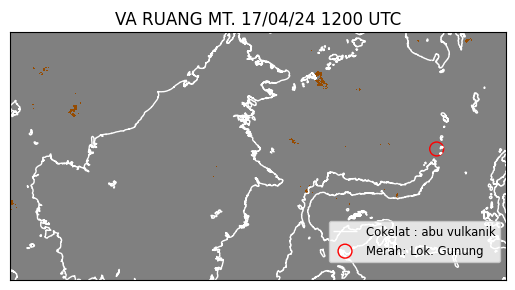

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


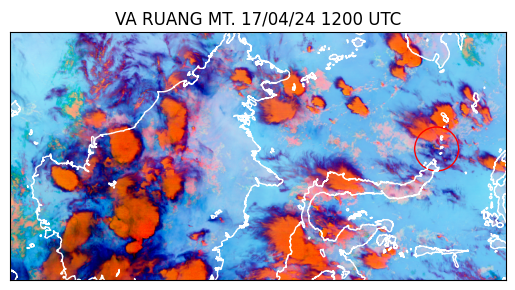

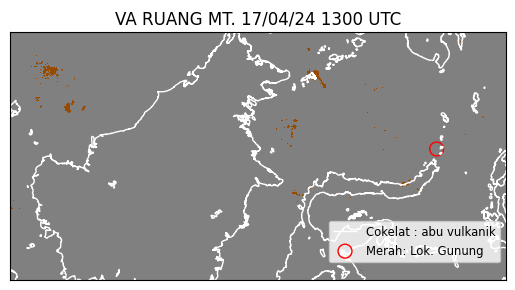

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


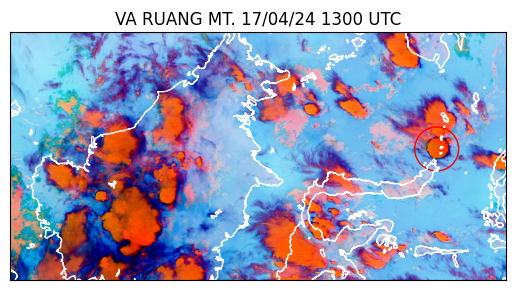

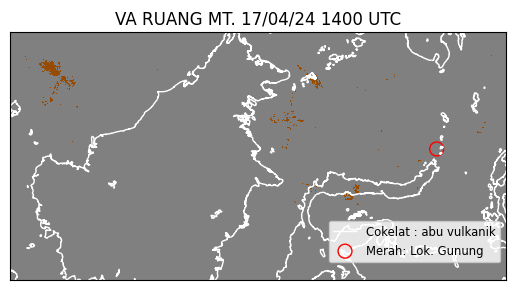

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


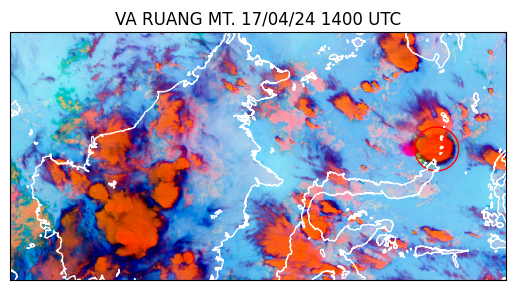

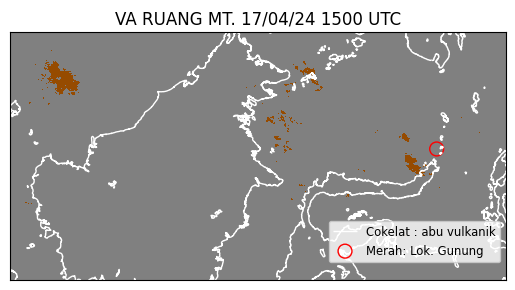

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


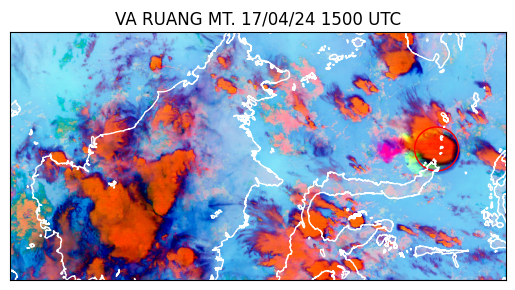

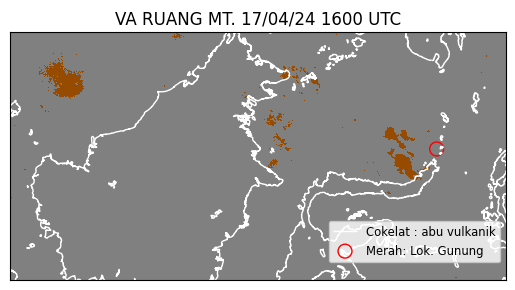

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


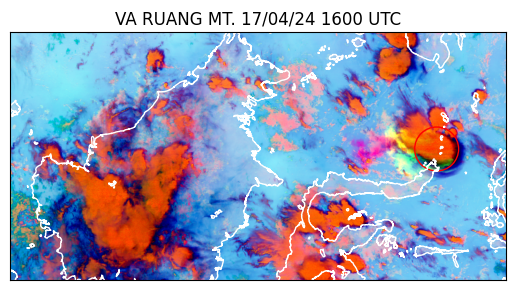

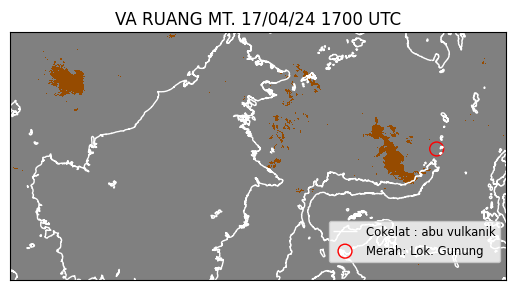

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


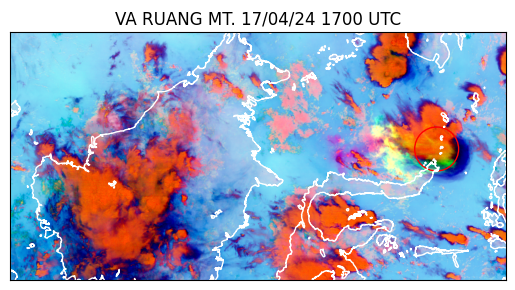

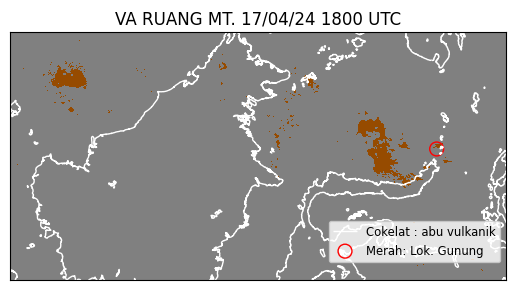

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


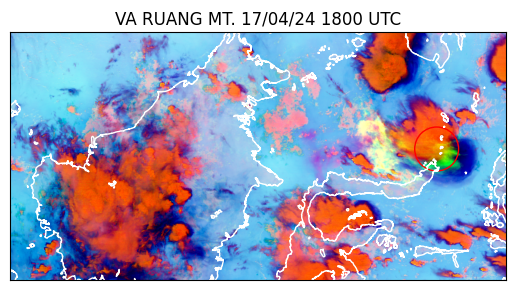

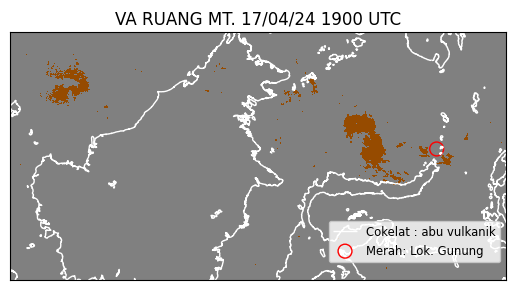

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


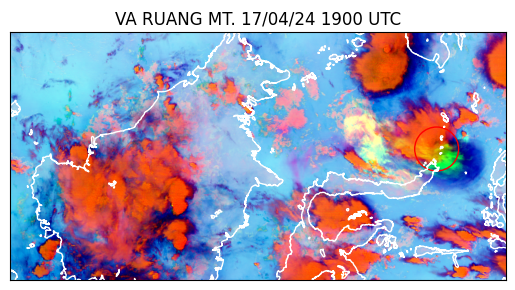

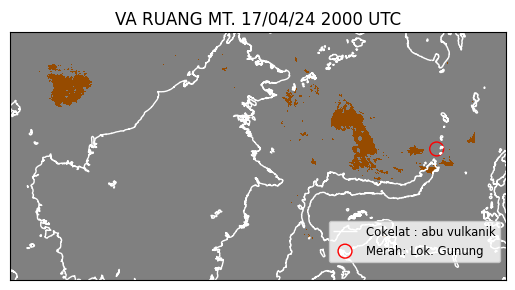

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


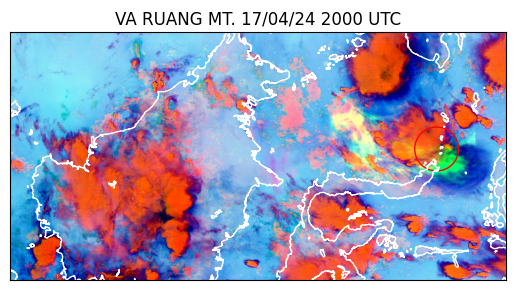

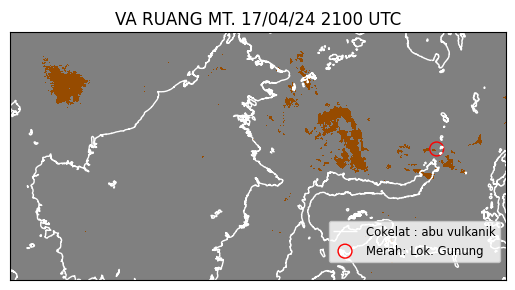

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


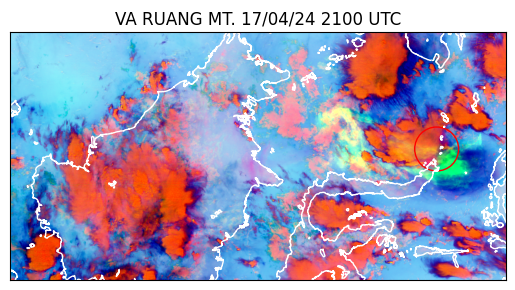

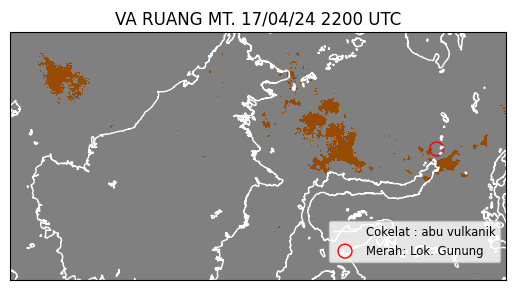

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


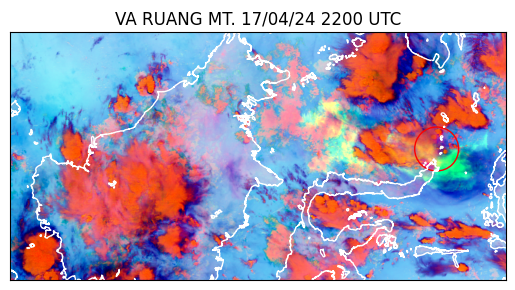

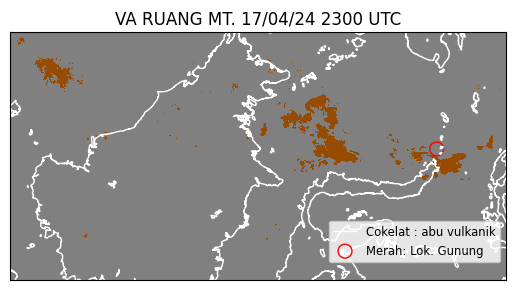

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


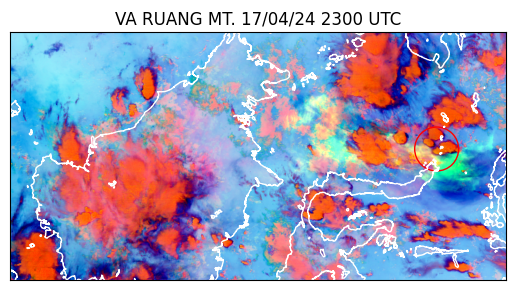

In [15]:
time1 = [1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300]
time2 = [1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300]

time3 = [2230]
for time in time3:
    data55 = f'H09_B11_Indonesia_20240419{time}.nc'
    data56 = f'H09_B13_Indonesia_20240419{time}.nc'
    data57 = f'H09_B15_Indonesia_20240419{time}.nc'

    plot18= rgb2(data55, data56, data57, PATH, f'VA RUANG MT. 19/04/24 {time} UTC', circles=[(125.20381, 2.28293, 10)])
    plot18= rgb1(data55, data56, data57, PATH, f'VA RUANG MT. 19/04/24 {time} UTC', circles=[(125.20381, 2.28293, 10)])


c:\Users\ulilh\miniconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


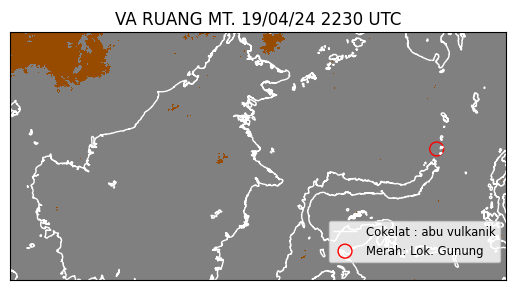

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


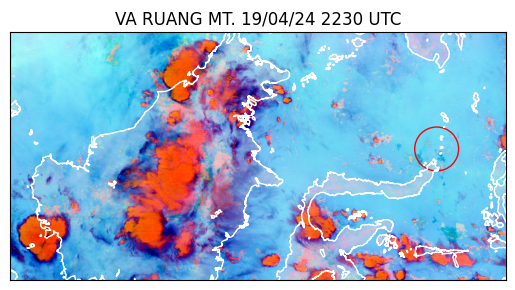

In [16]:
time3 = [2230]
for time in time3:
    data55 = f'H09_B11_Indonesia_20240419{time}.nc'
    data56 = f'H09_B13_Indonesia_20240419{time}.nc'
    data57 = f'H09_B15_Indonesia_20240419{time}.nc'

    plot18= rgb2(data55, data56, data57, PATH, f'VA RUANG MT. 19/04/24 {time} UTC', circles=[(125.20381, 2.28293, 10)])
    plot18= rgb1(data55, data56, data57, PATH, f'VA RUANG MT. 19/04/24 {time} UTC', circles=[(125.20381, 2.28293, 10)])
